# Scoring the Modernity of a Car 

Design Modernity Score:
- Assumption:  
    - the newer the car (wrt production year), the more modern it is
- Calculation:
    - weighted sum of the production year category labels:
        weigh labels (0, 1, 2, 3, etc.) by respective predicted probability 

In [1]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

import sys

sys.path.insert(0, "..")
import plotting_utils
from plotting_utils import config
from tueplots import figsizes

config.experiment_name = "modernity"
config.target = "nyu"
config.debug_mode = True

plt.rcParams.update(config.tueplots_bundle())

# Data Wrangling
import pandas as pd

# Machine Learning
import numpy as np
import torch

# Project 
from data.car_dataset import (
    CarDataset,
    data_transforms,
    year2label_fn,label2year_fn
)
from data.data_splitting import split_dataset_dfs
from metrics import modernity_score
from models import get_fine_tuned_model

In [2]:
# Load data
features_df = pd.read_csv("../../raw_data/tables/features.csv")
train_df, val_df, test_df = split_dataset_dfs("../../raw_data/tables/features.csv")

min_year = features_df["Launch_Year"].min()  # oldest car launch_year in data
max_year = features_df["Launch_Year"].max()
year_bucket_size = 2
year_range = max_year - min_year
num_year_classes = 1 + (year_range // year_bucket_size)  # floor division


dataset_train = CarDataset(
    features=train_df,
    transform=data_transforms["train"],
    year2label_fn=lambda year: year2label_fn(
        year, min_year=min_year, max_year=max_year, year_bucket_size=year_bucket_size
    ),
    img_root_dir="../../raw_data/",
)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=100, shuffle=True
)

In [3]:
# Get image
(
    img_tens,
    body_type,
    _,
    launch_year,
    bodytype_label,
    year_label,
    view_angle,
) = dataset_train[0]

In [4]:
# Load trained model
model = get_fine_tuned_model(
    num_classes=num_year_classes, path_to_weights="../model_weights.pt"
)

In [5]:
from torch.nn.functional import softmax

# Predict modernity
predicted_probs = softmax(
    model(img_tens.unsqueeze(0)), dim=1
)  # Need to add batch dimension to img
modernity_score(predicted_probs)

tensor([12.0420], grad_fn=<SumBackward1>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


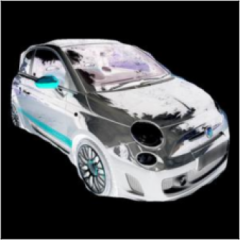

In [6]:
plotting_utils.imshow(dataset_train[0][0])

In [7]:
# Get batch of images
torch.manual_seed(13)

(
    img_tens,
    body_type,
    _,
    launch_year,
    bodytype_label,
    year_label,
    view_angle,
) = next(iter(dataloader_train))

In [8]:
# Predict on batch of images
model_pred_probs = softmax(model(img_tens), dim=1)

modernity_scores_batch = modernity_score(model_pred_probs)

In [9]:
# Get unique years and indices from year_label
unique_years, idcs_unique_years = np.unique(year_label.numpy(), return_index=True)

# Get images, one per year
unique_years_img_tens = img_tens[idcs_unique_years]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


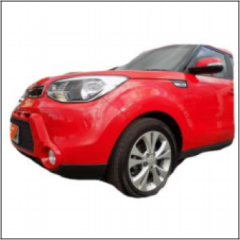

In [10]:
plotting_utils.imshow(unique_years_img_tens[7])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

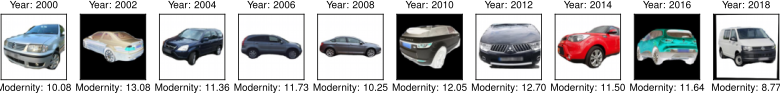

In [11]:
# Plot one car per unique year and the modernity score

with plt.rc_context(
    config.tueplots_bundle(rel_width=2, nrows=2, ncols=len(unique_years))
):
    fig, axs = plt.subplots(nrows=1, ncols=len(unique_years))

    for i, year in enumerate(unique_years):
        plotting_utils.imshow(
            unique_years_img_tens[i],
            ax=axs[i],
        )
        axs[i].set_title(
            f"Year: {label2year_fn(year,min_year=min_year,max_year=max_year,year_bucket_size=year_bucket_size)}"
        )
        axs[i].set(xlabel=f"Modernity: {modernity_scores_batch[i]:.2f}")

    plotting_utils.savefig(
        f"modernity_score_per_year",
        extension="png",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0.01,
    )